## Initialize

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import to_categorical

import time
import keras.backend as K
from keras import Input, Model
from keras.layers import Convolution2D, LeakyReLU, BatchNormalization, Conv2D, UpSampling2D, Subtract, Concatenate, Softmax, Dropout, Activation,MaxPooling2D, Flatten, Dense, Lambda, Reshape, concatenate, ZeroPadding2D, Cropping2D
from keras.optimizers import Adam
import tensorflow as tf

In [ ]:
bev='0.npy'
img= np.load(bev)
plt.imshow(img)
plt.axis('off')
plt.show()

## Reloading Data

In [ ]:
!cp '/content/birds_eye_data_final.zip' 'birds_eye_data.zip'
!unzip '/content/birds_eye_data_final.zip'

Streaming output truncated to the last 5000 lines.
  inflating: data/right/40170.npy    
  inflating: data/right/32064.npy    
  inflating: data/right/36996.npy    
  inflating: data/right/36932.npy    
  inflating: data/right/20050.npy    
  inflating: data/right/15450.npy    
  inflating: data/right/22703.npy    
  inflating: data/right/11843.npy    
  inflating: data/right/24417.npy    
  inflating: data/right/26061.npy    
  inflating: data/right/41115.npy    
  inflating: data/right/32412.npy    
  inflating: data/right/428.npy      
  inflating: data/right/8140.npy     
  inflating: data/right/20966.npy    
  inflating: data/right/30368.npy    
  inflating: data/right/45622.npy    
  inflating: data/right/4634.npy     
  inflating: data/right/16072.npy    
  inflating: data/right/40601.npy    
  inflating: data/right/18667.npy    
  inflating: data/right/44578.npy    
  inflating: data/right/45098.npy    
  inflating: data/right/5655.npy     
  inflating: data/right/43935.npy    

In [ ]:
def plot_cameras(sequence_number):

  rows = 2
  columns = 3
  fig=plt.figure(figsize=(10, 10))
  imgs = []
  cameras = ['left', 'front','right', 'back','top']

  for i, camera in enumerate(cameras):
    sample = np.load(f"./data/{camera}/{sequence_number}.npy")
    print(sample.shape)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(sample, cmap='gist_stern')

  plt.show()

(200, 300)
(200, 300)
(200, 300)
(200, 300)
(300, 200)


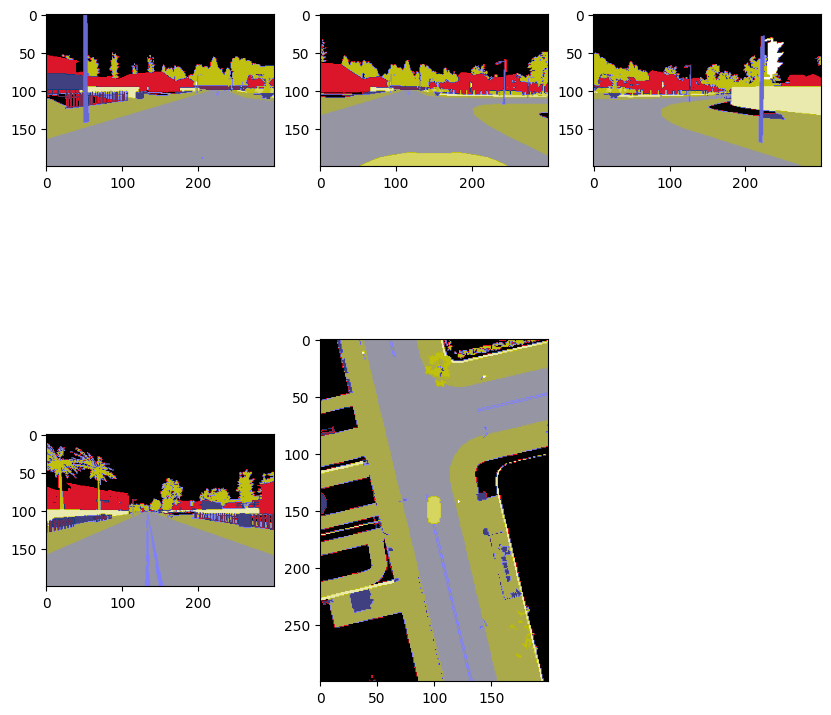

In [ ]:
plot_cameras(100)

In [ ]:
import os

def get_paths(val_size=5000):

  img_paths = []

  for i in range(len(os.listdir('./data/top'))):
    path = f'{i}.npy'
    img_paths.append(path)

  return pd.DataFrame({'path':img_paths[:-val_size]}), pd.DataFrame({'path':img_paths[-val_size:]})

In [ ]:
img_paths_train, img_paths_val = get_paths()
img_paths_train

In [ ]:
img_paths_val

## Setting up Data Generators

In [ ]:
def img_to_categorical(img, needed_labels):
  cat = np.empty((img.shape[0], img.shape[1], len(needed_labels)))

  for channel, label in enumerate(needed_labels):
    cat[:, :, channel] = np.where(np.isin(img, label), 1, 0)

  return cat

def categorical_to_img(cat):

  img = np.argmax(cat, axis=-1)
  return img

needed_labels = [0, 1, 6, 7, 8, 10, 11]

In [ ]:
from tensorflow.keras.utils import Sequence

class DataGenerator2D(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, img_paths, base_path, to_fit=True, batch_size=32, shuffle=True, needed_classes = []):

        self.img_paths = img_paths.copy()
        self.base_path = base_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.needed_classes = needed_classes
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(len(self.img_paths) // self.batch_size)

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        current_indexes = list(range(index * self.batch_size, (index + 1) * self.batch_size))
        img_paths_temp = self.img_paths[current_indexes]

        # Generate data
        X = self._generate_X(img_paths_temp)

        if self.to_fit:
            y = self._generate_y(img_paths_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.shuffle == True:
            indices = np.arange(len(self.img_paths))
            np.random.shuffle(indices)
            self.img_paths = self.img_paths[indices]
            self.img_paths.reset_index(drop=True, inplace=True)


    def _generate_X(self, img_paths_temp):
        """Generates data containing batch_size images
        :param img_paths_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization

        X = []

        # Generate data
        for idx, path in zip(img_paths_temp.index, img_paths_temp):
            # Store sample
            img = self._load_image(path)
            X.append(img)

        return np.array(X)

    def _generate_y(self, img_paths_temp):

        y = []

        for idx, path in zip(img_paths_temp.index, img_paths_temp):
            # Store sample
            img = self._load_image(path, front=False)
            y.append(img)
        return np.array(y)

    def _load_image(self, image_path, front=True):

        if front:
          img_dir =  '/front/'
        else:
          img_dir =  '/top/'

        img = np.load(self.base_path + img_dir + image_path)
        img = img[::2, ::2]                                          # Downsampling image by factor of 2

        if not front:
          img = img[3:(img.shape[0]//2)]
          img = np.rot90(img)
          img = img[2:-2]                                           # Crop Image to make dimensions divisible by 8
          img = img_to_categorical(img, self.needed_classes)

          return img

        img = img[2:-2, 3:-3]                                       # Crop Image to make dimensions divisible by 8
        img = img_to_categorical(img, self.needed_classes)

        return img

In [ ]:
print(img_paths_train['path'])
train_generator = DataGenerator2D(img_paths_train['path'], './data', batch_size=64, shuffle=True, needed_classes=needed_labels)
val_generator = DataGenerator2D(img_paths_val['path'], './data', batch_size=1, shuffle=False, needed_classes=needed_labels)

0            0.npy
1            1.npy
2            2.npy
3            3.npy
4            4.npy
           ...    
40995    40995.npy
40996    40996.npy
40997    40997.npy
40998    40998.npy
40999    40999.npy
Name: path, Length: 41000, dtype: object


In [ ]:
# Test the generator

X, y = train_generator.__getitem__(0)
print(X.shape, y.shape)

(64, 96, 144, 7) (64, 96, 72, 7)


(96, 144, 7)
(96, 144, 7)
(96, 144, 7)
(96, 144, 7)
(96, 144, 7)
(96, 144, 7)
(96, 144, 7)
(96, 144, 7)
(96, 144, 7)
(96, 144, 7)
(96, 144, 7)
(96, 144, 7)
(96, 144, 7)
(96, 144, 7)
(96, 144, 7)
(96, 144, 7)


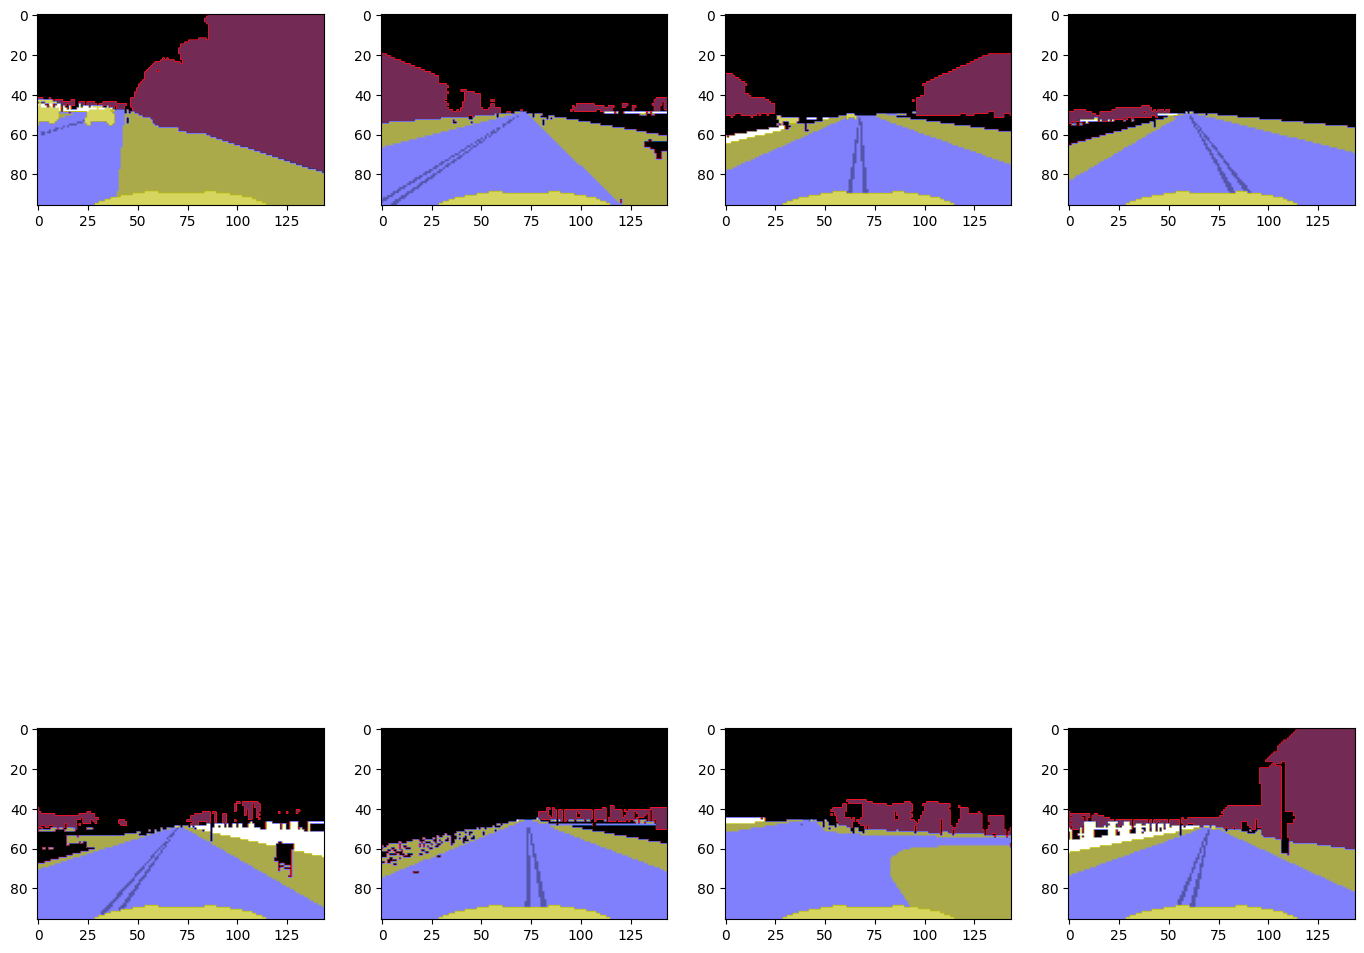

In [ ]:
fig=plt.figure(figsize=(17, 17))
columns = 4
rows = 2
for i in range(1, columns*rows + 1):
    img = X[i-1]
    print(img.shape)
    fig.add_subplot(rows, columns, i)
    plt.imshow(categorical_to_img(img), cmap='gist_stern', vmin=0, vmax=len(needed_labels)-1)
    print(img.shape)
plt.show()

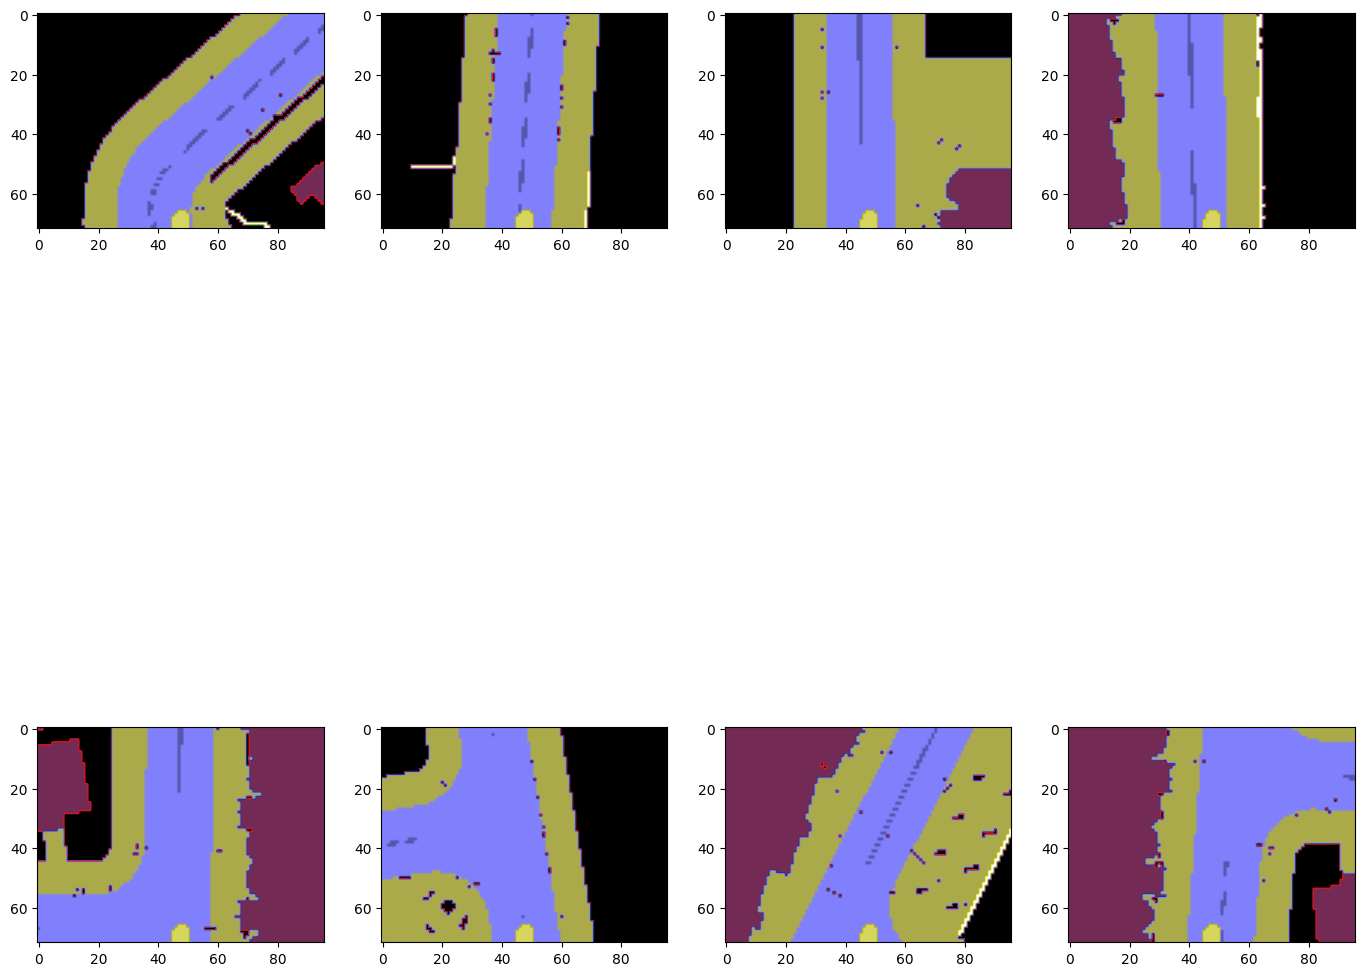

In [ ]:
fig=plt.figure(figsize=(17, 17))
columns = 4
rows = 2
for i in range(1, columns*rows + 1):
    img = y[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.rot90(categorical_to_img(img), 3), cmap='gist_stern', vmin=0, vmax=len(needed_labels)-1)
plt.show()

In [ ]:
import time
import keras.backend as K
from keras import Input, Model
from keras.layers import Convolution2D, LeakyReLU, BatchNormalization, UpSampling2D, Subtract, Concatenate, Softmax, Dropout, Activation,MaxPooling2D, Flatten, Dense, Lambda, Reshape, concatenate, ZeroPadding2D, Cropping2D
from keras.optimizers import Adam
from keras import Sequential

In [ ]:
def build_unet_generator(needed_labels):

  """
  Create U-Net Generator using the hyperparameter values defined
  below
  """

  kernel_size = [8, 6, 4, 6, 6, 8]
  strides = 2
  leakyrelu_alpha = 0.2
  upsampling_size = 2
  output_channels = len(needed_labels)
  input_shape = (96, 144, len(needed_labels))

  # Setting up the input
  input_layer = Input(shape=input_shape)

  # Encoder Network

  # 1st Convolutional block in the encoder network
  encoder1 = Convolution2D(filters=64, kernel_size=8,
  padding='same',
  strides=strides)(input_layer)
  encoder1 = LeakyReLU(alpha=leakyrelu_alpha)(encoder1)
  # 2nd Convolutional block in the encoder network
  encoder2 = Convolution2D(filters=128, kernel_size=6,
  padding='same',
  strides=strides)(encoder1)
  encoder2 = BatchNormalization()(encoder2)
  encoder2 = LeakyReLU(alpha=leakyrelu_alpha)(encoder2)
  # 3rd Convolutional block in the encoder network
  encoder3 = Convolution2D(filters=256, kernel_size=4,
  padding='same',
  strides=strides)(encoder2)
  encoder3 = BatchNormalization()(encoder3)
  encoder3 = LeakyReLU(alpha=leakyrelu_alpha)(encoder3)

  # 1st Upsampling Convolutional block in the decoder network
  decoder6 = UpSampling2D(size=upsampling_size)(encoder3)
  decoder6 = Convolution2D(filters=128, kernel_size=6,
  padding='same')(decoder6)
  decoder6 = BatchNormalization()(decoder6)
  decoder6 = concatenate([decoder6, encoder2])
  decoder6 = LeakyReLU(alpha=leakyrelu_alpha)(decoder6)
  # 2nd Upsampling Convolutional block in the decoder network
  decoder7 = UpSampling2D(size=upsampling_size)(decoder6)
  decoder7 = Convolution2D(filters=64, kernel_size=6,
  padding='same')(decoder7)
  decoder7 = BatchNormalization()(decoder7)
  decoder7 = concatenate([decoder7, encoder1])
  decoder7 = LeakyReLU(alpha=leakyrelu_alpha)(decoder7)


  # Last Convolutional layer
  decoder8 = UpSampling2D(size=(2, 1))(decoder7)
  decoder8 = Convolution2D(filters=output_channels,
  kernel_size=8, padding='same')(decoder8)
  decoder8 = Activation('softmax')(decoder8)

  model = Model(inputs=[input_layer], outputs=[decoder8])

  return model

In [ ]:
def get_model(needed_labels):
    model = Sequential()

    model.add(Conv2D(16, (5, 5), strides=2, padding='same', input_shape=(96, 144, len(needed_labels))))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(32, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(64, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(64, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 1)))
    model.add(Conv2D(16, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(len(needed_labels), (5, 5), activation='softmax', padding='same'))

    return model

model = get_model(needed_labels)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 72, 16)        2816      
                                                                 
 batch_normalization (Batch  (None, 48, 72, 16)        64        
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 72, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 36, 32)        12832     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 36, 32)        128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 36, 32)        0

In [ ]:
def get_model(needed_labels):
    model = Sequential()

    model.add(Conv2D(32, (5, 5), strides=2, padding='same', input_shape=(96, 144, len(needed_labels))))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(64, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D((2, 1)))
    model.add(Conv2D(32, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(len(needed_labels), (5, 5), activation='softmax', padding='same'))

    return model

model = get_model(needed_labels)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 48, 72, 32)        5632      
                                                                 
 batch_normalization_12 (Ba  (None, 48, 72, 32)        128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 48, 72, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 36, 64)        51264     
                                                                 
 batch_normalization_13 (Ba  (None, 24, 36, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 24, 36, 64)       

In [ ]:
model = build_unet_generator(needed_labels)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 144, 7)]         0         []                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 48, 72, 64)           28736     ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu_24 (LeakyReLU)  (None, 48, 72, 64)           0         ['conv2d_26[0][0]']           
                                                                                                  
 conv2d_27 (Conv2D)          (None, 24, 36, 128)          295040    ['leaky_re_lu_24[0][0]']      
                                                                                              

In [ ]:
# Checking if the model can run at real time on current GPU at specified fps

from time import time
fps = 30

x = np.random.random((96, 144, len(needed_labels)))
start = time()

for i in range(fps):
  out = model.predict(np.array([x]))

print(time() - start)

1/1 [==============================] - 0s 18ms/step
4.15068244934082


In [ ]:
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from time import time

optimizer = Nadam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)


In [ ]:
tensorboard = TensorBoard(log_dir="./drive/My Drive/BEV/logs/Birds_Eye{}".format(time()))
early_stopping = EarlyStopping(monitor='val_loss', patience=30)

filepath = "./drive/My Drive/BEV/Birds Eye 2/" + "Birds Eye cat simple-2-" + "saved-model-{epoch:02d}-{val_loss:.5f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False)
callbacks_list = [checkpoint, tensorboard]

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=len(needed_labels)):
    dice=0
    for index in range(0, numLabels):
        dice -= dice_coef(y_true[:, :, :, index], y_pred[:, :, :, index])
    return numLabels + dice

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def custom_loss(y_true, y_pred):
    return dice_coef_multilabel(y_true, y_pred) + 5*ssim_loss(y_true, y_pred)

In [ ]:
model.compile(optimizer='adam', loss=dice_coef_multilabel, metrics=['categorical_accuracy'])

In [ ]:
# Simple FCN with small bottleneck results (Dice Loss)

NUM_EPOCHS = 100

history = model.fit(train_generator, epochs=NUM_EPOCHS,
                              shuffle=True,
                              callbacks=callbacks_list,
                              validation_data= val_generator)

Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 4.1009 - categorical_accuracy: 0.6016
Epoch 1: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-01-4.15734.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 316s 492ms/step - loss: 4.1009 - categorical_accuracy: 0.6016 - val_loss: 4.1573 - val_categorical_accuracy: 0.5766
Epoch 2/100
640/640 [==============================] - ETA: 0s - loss: 3.6230 - categorical_accuracy: 0.6544
Epoch 2: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-02-3.44813.hdf5
640/640 [==============================] - 297s 464ms/step - loss: 3.6230 - categorical_accuracy: 0.6544 - val_loss: 3.4481 - val_categorical_accuracy: 0.6259


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/100
640/640 [==============================] - ETA: 0s - loss: 3.3841 - categorical_accuracy: 0.6831
Epoch 3: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-03-3.24871.hdf5
640/640 [==============================] - 295s 461ms/step - loss: 3.3841 - categorical_accuracy: 0.6831 - val_loss: 3.2487 - val_categorical_accuracy: 0.6491


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 4/100
640/640 [==============================] - ETA: 0s - loss: 3.2598 - categorical_accuracy: 0.6988
Epoch 4: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-04-3.16724.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 296s 463ms/step - loss: 3.2598 - categorical_accuracy: 0.6988 - val_loss: 3.1672 - val_categorical_accuracy: 0.6610
Epoch 5/100
640/640 [==============================] - ETA: 0s - loss: 3.1827 - categorical_accuracy: 0.7090
Epoch 5: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-05-3.16862.hdf5
640/640 [==============================] - 298s 466ms/step - loss: 3.1827 - categorical_accuracy: 0.7090 - val_loss: 3.1686 - val_categorical_accuracy: 0.6722


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 6/100
640/640 [==============================] - ETA: 0s - loss: 3.1223 - categorical_accuracy: 0.7170
Epoch 6: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-06-3.12276.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 297s 464ms/step - loss: 3.1223 - categorical_accuracy: 0.7170 - val_loss: 3.1228 - val_categorical_accuracy: 0.6759
Epoch 7/100
640/640 [==============================] - ETA: 0s - loss: 3.0732 - categorical_accuracy: 0.7236
Epoch 7: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-07-3.06302.hdf5
640/640 [==============================] - 294s 459ms/step - loss: 3.0732 - categorical_accuracy: 0.7236 - val_loss: 3.0630 - val_categorical_accuracy: 0.6875


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 8/100
640/640 [==============================] - ETA: 0s - loss: 3.0324 - categorical_accuracy: 0.7291
Epoch 8: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-08-3.03598.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 297s 463ms/step - loss: 3.0324 - categorical_accuracy: 0.7291 - val_loss: 3.0360 - val_categorical_accuracy: 0.6917
Epoch 9/100
640/640 [==============================] - ETA: 0s - loss: 2.9970 - categorical_accuracy: 0.7339
Epoch 9: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-09-3.06654.hdf5
640/640 [==============================] - 301s 470ms/step - loss: 2.9970 - categorical_accuracy: 0.7339 - val_loss: 3.0665 - val_categorical_accuracy: 0.6927


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 10/100
640/640 [==============================] - ETA: 0s - loss: 2.9678 - categorical_accuracy: 0.7376
Epoch 10: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-10-3.02862.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 298s 465ms/step - loss: 2.9678 - categorical_accuracy: 0.7376 - val_loss: 3.0286 - val_categorical_accuracy: 0.7030
Epoch 11/100
640/640 [==============================] - ETA: 0s - loss: 2.9415 - categorical_accuracy: 0.7412
Epoch 11: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-11-3.01731.hdf5
640/640 [==============================] - 296s 462ms/step - loss: 2.9415 - categorical_accuracy: 0.7412 - val_loss: 3.0173 - val_categorical_accuracy: 0.6988
Epoch 12/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - ETA: 0s - loss: 2.9163 - categorical_accuracy: 0.7442
Epoch 12: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-12-2.94128.hdf5
640/640 [==============================] - 304s 475ms/step - loss: 2.9163 - categorical_accuracy: 0.7442 - val_loss: 2.9413 - val_categorical_accuracy: 0.7043


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 13/100
640/640 [==============================] - ETA: 0s - loss: 2.8920 - categorical_accuracy: 0.7474
Epoch 13: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-13-2.95765.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 296s 462ms/step - loss: 2.8920 - categorical_accuracy: 0.7474 - val_loss: 2.9576 - val_categorical_accuracy: 0.7069
Epoch 14/100
640/640 [==============================] - ETA: 0s - loss: 2.8718 - categorical_accuracy: 0.7500
Epoch 14: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-14-2.97408.hdf5
640/640 [==============================] - 335s 524ms/step - loss: 2.8718 - categorical_accuracy: 0.7500 - val_loss: 2.9741 - val_categorical_accuracy: 0.7097


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 15/100
640/640 [==============================] - ETA: 0s - loss: 2.8520 - categorical_accuracy: 0.7525
Epoch 15: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-15-2.93677.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 297s 463ms/step - loss: 2.8520 - categorical_accuracy: 0.7525 - val_loss: 2.9368 - val_categorical_accuracy: 0.7108
Epoch 16/100
640/640 [==============================] - ETA: 0s - loss: 2.8340 - categorical_accuracy: 0.7548
Epoch 16: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-16-2.95827.hdf5
640/640 [==============================] - 304s 476ms/step - loss: 2.8340 - categorical_accuracy: 0.7548 - val_loss: 2.9583 - val_categorical_accuracy: 0.7145


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 17/100
640/640 [==============================] - ETA: 0s - loss: 2.8139 - categorical_accuracy: 0.7569
Epoch 17: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-17-2.90967.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 305s 476ms/step - loss: 2.8139 - categorical_accuracy: 0.7569 - val_loss: 2.9097 - val_categorical_accuracy: 0.7172
Epoch 18/100
640/640 [==============================] - ETA: 0s - loss: 2.7989 - categorical_accuracy: 0.7587
Epoch 18: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-18-2.92571.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 308s 481ms/step - loss: 2.7989 - categorical_accuracy: 0.7587 - val_loss: 2.9257 - val_categorical_accuracy: 0.7132
Epoch 19/100
640/640 [==============================] - ETA: 0s - loss: 2.7829 - categorical_accuracy: 0.7606
Epoch 19: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-19-2.88542.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 310s 485ms/step - loss: 2.7829 - categorical_accuracy: 0.7606 - val_loss: 2.8854 - val_categorical_accuracy: 0.7182
Epoch 20/100
640/640 [==============================] - ETA: 0s - loss: 2.7716 - categorical_accuracy: 0.7622
Epoch 20: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-20-2.91523.hdf5
640/640 [==============================] - 313s 489ms/step - loss: 2.7716 - categorical_accuracy: 0.7622 - val_loss: 2.9152 - val_categorical_accuracy: 0.7165


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 21/100
640/640 [==============================] - ETA: 0s - loss: 2.7560 - categorical_accuracy: 0.7638
Epoch 21: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-21-2.90962.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 311s 486ms/step - loss: 2.7560 - categorical_accuracy: 0.7638 - val_loss: 2.9096 - val_categorical_accuracy: 0.7191
Epoch 22/100
640/640 [==============================] - ETA: 0s - loss: 2.7414 - categorical_accuracy: 0.7654
Epoch 22: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-22-2.89910.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 313s 489ms/step - loss: 2.7414 - categorical_accuracy: 0.7654 - val_loss: 2.8991 - val_categorical_accuracy: 0.7200
Epoch 23/100
640/640 [==============================] - ETA: 0s - loss: 2.7253 - categorical_accuracy: 0.7671
Epoch 23: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-23-2.87537.hdf5
640/640 [==============================] - 301s 470ms/step - loss: 2.7253 - categorical_accuracy: 0.7671 - val_loss: 2.8754 - val_categorical_accuracy: 0.7157


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 24/100
640/640 [==============================] - ETA: 0s - loss: 2.7151 - categorical_accuracy: 0.7681
Epoch 24: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-24-2.87554.hdf5
640/640 [==============================] - 309s 483ms/step - loss: 2.7151 - categorical_accuracy: 0.7681 - val_loss: 2.8755 - val_categorical_accuracy: 0.7210


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 25/100
640/640 [==============================] - ETA: 0s - loss: 2.7060 - categorical_accuracy: 0.7692
Epoch 25: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-25-2.88388.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 305s 477ms/step - loss: 2.7060 - categorical_accuracy: 0.7692 - val_loss: 2.8839 - val_categorical_accuracy: 0.7217
Epoch 26/100
640/640 [==============================] - ETA: 0s - loss: 2.6917 - categorical_accuracy: 0.7709
Epoch 26: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-26-2.87983.hdf5
640/640 [==============================] - 309s 482ms/step - loss: 2.6917 - categorical_accuracy: 0.7709 - val_loss: 2.8798 - val_categorical_accuracy: 0.7249


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 27/100
640/640 [==============================] - ETA: 0s - loss: 2.6785 - categorical_accuracy: 0.7722
Epoch 27: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-27-2.84760.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 312s 488ms/step - loss: 2.6785 - categorical_accuracy: 0.7722 - val_loss: 2.8476 - val_categorical_accuracy: 0.7223
Epoch 28/100
640/640 [==============================] - ETA: 0s - loss: 2.6704 - categorical_accuracy: 0.7734
Epoch 28: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-28-2.87040.hdf5
640/640 [==============================] - 319s 498ms/step - loss: 2.6704 - categorical_accuracy: 0.7734 - val_loss: 2.8704 - val_categorical_accuracy: 0.7267


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 29/100
640/640 [==============================] - ETA: 0s - loss: 2.6593 - categorical_accuracy: 0.7745
Epoch 29: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-29-2.85184.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 350s 546ms/step - loss: 2.6593 - categorical_accuracy: 0.7745 - val_loss: 2.8518 - val_categorical_accuracy: 0.7267
Epoch 30/100
640/640 [==============================] - ETA: 0s - loss: 2.6509 - categorical_accuracy: 0.7756
Epoch 30: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-30-2.85757.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 312s 487ms/step - loss: 2.6509 - categorical_accuracy: 0.7756 - val_loss: 2.8576 - val_categorical_accuracy: 0.7246
Epoch 31/100
640/640 [==============================] - ETA: 0s - loss: 2.6405 - categorical_accuracy: 0.7764
Epoch 31: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-31-2.88269.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 302s 471ms/step - loss: 2.6405 - categorical_accuracy: 0.7764 - val_loss: 2.8827 - val_categorical_accuracy: 0.7252
Epoch 32/100
640/640 [==============================] - ETA: 0s - loss: 2.6329 - categorical_accuracy: 0.7776
Epoch 32: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-32-2.83408.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 351s 548ms/step - loss: 2.6329 - categorical_accuracy: 0.7776 - val_loss: 2.8341 - val_categorical_accuracy: 0.7272
Epoch 33/100
640/640 [==============================] - ETA: 0s - loss: 2.6211 - categorical_accuracy: 0.7787
Epoch 33: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-33-2.85324.hdf5
640/640 [==============================] - 351s 548ms/step - loss: 2.6211 - categorical_accuracy: 0.7787 - val_loss: 2.8532 - val_categorical_accuracy: 0.7284


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 34/100
640/640 [==============================] - ETA: 0s - loss: 2.6110 - categorical_accuracy: 0.7796
Epoch 34: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-34-2.87280.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 307s 480ms/step - loss: 2.6110 - categorical_accuracy: 0.7796 - val_loss: 2.8728 - val_categorical_accuracy: 0.7300
Epoch 35/100
640/640 [==============================] - ETA: 0s - loss: 2.6088 - categorical_accuracy: 0.7802
Epoch 35: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-35-2.88070.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 346s 541ms/step - loss: 2.6088 - categorical_accuracy: 0.7802 - val_loss: 2.8807 - val_categorical_accuracy: 0.7276
Epoch 36/100
640/640 [==============================] - ETA: 0s - loss: 2.5955 - categorical_accuracy: 0.7814
Epoch 36: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-36-2.83974.hdf5
640/640 [==============================] - 302s 472ms/step - loss: 2.5955 - categorical_accuracy: 0.7814 - val_loss: 2.8397 - val_categorical_accuracy: 0.7283


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 37/100
640/640 [==============================] - ETA: 0s - loss: 2.5852 - categorical_accuracy: 0.7825
Epoch 37: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-37-2.84720.hdf5
640/640 [==============================] - 300s 469ms/step - loss: 2.5852 - categorical_accuracy: 0.7825 - val_loss: 2.8472 - val_categorical_accuracy: 0.7260


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 38/100
640/640 [==============================] - ETA: 0s - loss: 2.5810 - categorical_accuracy: 0.7832
Epoch 38: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-38-2.84358.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 302s 472ms/step - loss: 2.5810 - categorical_accuracy: 0.7832 - val_loss: 2.8436 - val_categorical_accuracy: 0.7307
Epoch 39/100
640/640 [==============================] - ETA: 0s - loss: 2.5740 - categorical_accuracy: 0.7840
Epoch 39: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-39-2.85631.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 308s 481ms/step - loss: 2.5740 - categorical_accuracy: 0.7840 - val_loss: 2.8563 - val_categorical_accuracy: 0.7321
Epoch 40/100
640/640 [==============================] - ETA: 0s - loss: 2.5663 - categorical_accuracy: 0.7847
Epoch 40: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-40-2.87996.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 348s 544ms/step - loss: 2.5663 - categorical_accuracy: 0.7847 - val_loss: 2.8800 - val_categorical_accuracy: 0.7314
Epoch 41/100
640/640 [==============================] - ETA: 0s - loss: 2.5567 - categorical_accuracy: 0.7858
Epoch 41: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-41-2.83639.hdf5
640/640 [==============================] - 354s 552ms/step - loss: 2.5567 - categorical_accuracy: 0.7858 - val_loss: 2.8364 - val_categorical_accuracy: 0.7323


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 42/100
640/640 [==============================] - ETA: 0s - loss: 2.5495 - categorical_accuracy: 0.7865
Epoch 42: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-42-2.82845.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 313s 489ms/step - loss: 2.5495 - categorical_accuracy: 0.7865 - val_loss: 2.8285 - val_categorical_accuracy: 0.7295
Epoch 43/100
640/640 [==============================] - ETA: 0s - loss: 2.5432 - categorical_accuracy: 0.7872
Epoch 43: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-43-2.86627.hdf5
640/640 [==============================] - 307s 479ms/step - loss: 2.5432 - categorical_accuracy: 0.7872 - val_loss: 2.8663 - val_categorical_accuracy: 0.7287


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 44/100
640/640 [==============================] - ETA: 0s - loss: 2.5365 - categorical_accuracy: 0.7878
Epoch 44: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-44-2.85784.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 304s 475ms/step - loss: 2.5365 - categorical_accuracy: 0.7878 - val_loss: 2.8578 - val_categorical_accuracy: 0.7346
Epoch 45/100
640/640 [==============================] - ETA: 0s - loss: 2.5327 - categorical_accuracy: 0.7881
Epoch 45: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-45-2.83927.hdf5
640/640 [==============================] - 299s 467ms/step - loss: 2.5327 - categorical_accuracy: 0.7881 - val_loss: 2.8393 - val_categorical_accuracy: 0.7341


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 46/100
640/640 [==============================] - ETA: 0s - loss: 2.5238 - categorical_accuracy: 0.7893
Epoch 46: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-46-2.85608.hdf5
640/640 [==============================] - 342s 534ms/step - loss: 2.5238 - categorical_accuracy: 0.7893 - val_loss: 2.8561 - val_categorical_accuracy: 0.7298


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 47/100
640/640 [==============================] - ETA: 0s - loss: 2.5165 - categorical_accuracy: 0.7899
Epoch 47: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-47-2.86824.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 299s 466ms/step - loss: 2.5165 - categorical_accuracy: 0.7899 - val_loss: 2.8682 - val_categorical_accuracy: 0.7334
Epoch 48/100
640/640 [==============================] - ETA: 0s - loss: 2.5113 - categorical_accuracy: 0.7907
Epoch 48: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-48-2.80292.hdf5
640/640 [==============================] - 305s 476ms/step - loss: 2.5113 - categorical_accuracy: 0.7907 - val_loss: 2.8029 - val_categorical_accuracy: 0.7304
Epoch 49/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - ETA: 0s - loss: 2.5052 - categorical_accuracy: 0.7914
Epoch 49: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-49-2.82880.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 303s 473ms/step - loss: 2.5052 - categorical_accuracy: 0.7914 - val_loss: 2.8288 - val_categorical_accuracy: 0.7345
Epoch 50/100
640/640 [==============================] - ETA: 0s - loss: 2.4986 - categorical_accuracy: 0.7919
Epoch 50: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-50-2.84507.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 347s 542ms/step - loss: 2.4986 - categorical_accuracy: 0.7919 - val_loss: 2.8451 - val_categorical_accuracy: 0.7330
Epoch 51/100
640/640 [==============================] - ETA: 0s - loss: 2.4930 - categorical_accuracy: 0.7924
Epoch 51: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-51-2.83966.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 301s 470ms/step - loss: 2.4930 - categorical_accuracy: 0.7924 - val_loss: 2.8397 - val_categorical_accuracy: 0.7338
Epoch 52/100
640/640 [==============================] - ETA: 0s - loss: 2.4896 - categorical_accuracy: 0.7929
Epoch 52: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-52-2.84537.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 306s 477ms/step - loss: 2.4896 - categorical_accuracy: 0.7929 - val_loss: 2.8454 - val_categorical_accuracy: 0.7314
Epoch 53/100
640/640 [==============================] - ETA: 0s - loss: 2.4823 - categorical_accuracy: 0.7937
Epoch 53: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-53-2.84006.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 297s 464ms/step - loss: 2.4823 - categorical_accuracy: 0.7937 - val_loss: 2.8401 - val_categorical_accuracy: 0.7350
Epoch 54/100
640/640 [==============================] - ETA: 0s - loss: 2.4775 - categorical_accuracy: 0.7941
Epoch 54: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-54-2.82746.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 314s 490ms/step - loss: 2.4775 - categorical_accuracy: 0.7941 - val_loss: 2.8275 - val_categorical_accuracy: 0.7347
Epoch 55/100
640/640 [==============================] - ETA: 0s - loss: 2.4699 - categorical_accuracy: 0.7952
Epoch 55: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-55-2.81141.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 306s 478ms/step - loss: 2.4699 - categorical_accuracy: 0.7952 - val_loss: 2.8114 - val_categorical_accuracy: 0.7353
Epoch 56/100
640/640 [==============================] - ETA: 0s - loss: 2.4659 - categorical_accuracy: 0.7953
Epoch 56: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-56-2.82649.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 344s 537ms/step - loss: 2.4659 - categorical_accuracy: 0.7953 - val_loss: 2.8265 - val_categorical_accuracy: 0.7339
Epoch 57/100
640/640 [==============================] - ETA: 0s - loss: 2.4600 - categorical_accuracy: 0.7960
Epoch 57: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-57-2.85116.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 300s 468ms/step - loss: 2.4600 - categorical_accuracy: 0.7960 - val_loss: 2.8512 - val_categorical_accuracy: 0.7349
Epoch 58/100
640/640 [==============================] - ETA: 0s - loss: 2.4542 - categorical_accuracy: 0.7967
Epoch 58: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-58-2.85014.hdf5
640/640 [==============================] - 344s 537ms/step - loss: 2.4542 - categorical_accuracy: 0.7967 - val_loss: 2.8501 - val_categorical_accuracy: 0.7353


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 59/100
640/640 [==============================] - ETA: 0s - loss: 2.4450 - categorical_accuracy: 0.7968
Epoch 59: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-59-2.84673.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 336s 525ms/step - loss: 2.4450 - categorical_accuracy: 0.7968 - val_loss: 2.8467 - val_categorical_accuracy: 0.7325
Epoch 60/100
640/640 [==============================] - ETA: 0s - loss: 2.4320 - categorical_accuracy: 0.7973
Epoch 60: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-60-2.84650.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 345s 539ms/step - loss: 2.4320 - categorical_accuracy: 0.7973 - val_loss: 2.8465 - val_categorical_accuracy: 0.7359
Epoch 61/100
640/640 [==============================] - ETA: 0s - loss: 2.4254 - categorical_accuracy: 0.7976
Epoch 61: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-61-2.82874.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 308s 481ms/step - loss: 2.4254 - categorical_accuracy: 0.7976 - val_loss: 2.8287 - val_categorical_accuracy: 0.7365
Epoch 62/100
640/640 [==============================] - ETA: 0s - loss: 2.4192 - categorical_accuracy: 0.7980
Epoch 62: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-62-2.80467.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 308s 480ms/step - loss: 2.4192 - categorical_accuracy: 0.7980 - val_loss: 2.8047 - val_categorical_accuracy: 0.7366
Epoch 63/100
640/640 [==============================] - ETA: 0s - loss: 2.4110 - categorical_accuracy: 0.7989
Epoch 63: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-63-2.81012.hdf5
640/640 [==============================] - 343s 536ms/step - loss: 2.4110 - categorical_accuracy: 0.7989 - val_loss: 2.8101 - val_categorical_accuracy: 0.7357


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 64/100
640/640 [==============================] - ETA: 0s - loss: 2.4057 - categorical_accuracy: 0.7994
Epoch 64: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-64-2.80086.hdf5
640/640 [==============================] - 310s 484ms/step - loss: 2.4057 - categorical_accuracy: 0.7994 - val_loss: 2.8009 - val_categorical_accuracy: 0.7368


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 65/100
640/640 [==============================] - ETA: 0s - loss: 2.3989 - categorical_accuracy: 0.7997
Epoch 65: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-65-2.82424.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 351s 547ms/step - loss: 2.3989 - categorical_accuracy: 0.7997 - val_loss: 2.8242 - val_categorical_accuracy: 0.7385
Epoch 66/100
640/640 [==============================] - ETA: 0s - loss: 2.3923 - categorical_accuracy: 0.8002
Epoch 66: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-66-2.83059.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 342s 534ms/step - loss: 2.3923 - categorical_accuracy: 0.8002 - val_loss: 2.8306 - val_categorical_accuracy: 0.7386
Epoch 67/100
640/640 [==============================] - ETA: 0s - loss: 2.3876 - categorical_accuracy: 0.8007
Epoch 67: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-67-2.82048.hdf5
640/640 [==============================] - 296s 461ms/step - loss: 2.3876 - categorical_accuracy: 0.8007 - val_loss: 2.8205 - val_categorical_accuracy: 0.7363


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 68/100
640/640 [==============================] - ETA: 0s - loss: 2.3815 - categorical_accuracy: 0.8012
Epoch 68: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-68-2.80193.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 306s 478ms/step - loss: 2.3815 - categorical_accuracy: 0.8012 - val_loss: 2.8019 - val_categorical_accuracy: 0.7357
Epoch 69/100
640/640 [==============================] - ETA: 0s - loss: 2.3747 - categorical_accuracy: 0.8017
Epoch 69: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-69-2.81507.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 344s 538ms/step - loss: 2.3747 - categorical_accuracy: 0.8017 - val_loss: 2.8151 - val_categorical_accuracy: 0.7349
Epoch 70/100
640/640 [==============================] - ETA: 0s - loss: 2.3701 - categorical_accuracy: 0.8022
Epoch 70: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-70-2.81496.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 300s 468ms/step - loss: 2.3701 - categorical_accuracy: 0.8022 - val_loss: 2.8150 - val_categorical_accuracy: 0.7374
Epoch 71/100
640/640 [==============================] - ETA: 0s - loss: 2.3649 - categorical_accuracy: 0.8028
Epoch 71: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-71-2.80621.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 301s 469ms/step - loss: 2.3649 - categorical_accuracy: 0.8028 - val_loss: 2.8062 - val_categorical_accuracy: 0.7383
Epoch 72/100
640/640 [==============================] - ETA: 0s - loss: 2.3597 - categorical_accuracy: 0.8031
Epoch 72: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-72-2.81947.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 309s 483ms/step - loss: 2.3597 - categorical_accuracy: 0.8031 - val_loss: 2.8195 - val_categorical_accuracy: 0.7396
Epoch 73/100
640/640 [==============================] - ETA: 0s - loss: 2.3561 - categorical_accuracy: 0.8034
Epoch 73: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-73-2.84664.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 349s 545ms/step - loss: 2.3561 - categorical_accuracy: 0.8034 - val_loss: 2.8466 - val_categorical_accuracy: 0.7356
Epoch 74/100
640/640 [==============================] - ETA: 0s - loss: 2.3512 - categorical_accuracy: 0.8038
Epoch 74: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-74-2.82199.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 307s 480ms/step - loss: 2.3512 - categorical_accuracy: 0.8038 - val_loss: 2.8220 - val_categorical_accuracy: 0.7353
Epoch 75/100
640/640 [==============================] - ETA: 0s - loss: 2.3450 - categorical_accuracy: 0.8045
Epoch 75: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-75-2.84995.hdf5
640/640 [==============================] - 344s 537ms/step - loss: 2.3450 - categorical_accuracy: 0.8045 - val_loss: 2.8500 - val_categorical_accuracy: 0.7380


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 76/100
640/640 [==============================] - ETA: 0s - loss: 2.3415 - categorical_accuracy: 0.8046
Epoch 76: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-76-2.81054.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 309s 483ms/step - loss: 2.3415 - categorical_accuracy: 0.8046 - val_loss: 2.8105 - val_categorical_accuracy: 0.7388
Epoch 77/100
640/640 [==============================] - ETA: 0s - loss: 2.3348 - categorical_accuracy: 0.8053
Epoch 77: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-77-2.82842.hdf5
640/640 [==============================] - 305s 477ms/step - loss: 2.3348 - categorical_accuracy: 0.8053 - val_loss: 2.8284 - val_categorical_accuracy: 0.7399


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 78/100
640/640 [==============================] - ETA: 0s - loss: 2.3326 - categorical_accuracy: 0.8054
Epoch 78: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-78-2.82820.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 307s 480ms/step - loss: 2.3326 - categorical_accuracy: 0.8054 - val_loss: 2.8282 - val_categorical_accuracy: 0.7381
Epoch 79/100
640/640 [==============================] - ETA: 0s - loss: 2.3281 - categorical_accuracy: 0.8058
Epoch 79: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-79-2.82471.hdf5
640/640 [==============================] - 311s 486ms/step - loss: 2.3281 - categorical_accuracy: 0.8058 - val_loss: 2.8247 - val_categorical_accuracy: 0.7397


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 80/100
640/640 [==============================] - ETA: 0s - loss: 2.3232 - categorical_accuracy: 0.8064
Epoch 80: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-80-2.80635.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 312s 487ms/step - loss: 2.3232 - categorical_accuracy: 0.8064 - val_loss: 2.8064 - val_categorical_accuracy: 0.7386
Epoch 81/100
640/640 [==============================] - ETA: 0s - loss: 2.3183 - categorical_accuracy: 0.8067
Epoch 81: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-81-2.83415.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 308s 482ms/step - loss: 2.3183 - categorical_accuracy: 0.8067 - val_loss: 2.8341 - val_categorical_accuracy: 0.7346
Epoch 82/100
640/640 [==============================] - ETA: 0s - loss: 2.3137 - categorical_accuracy: 0.8070
Epoch 82: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-82-2.81240.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 348s 544ms/step - loss: 2.3137 - categorical_accuracy: 0.8070 - val_loss: 2.8124 - val_categorical_accuracy: 0.7392
Epoch 83/100
640/640 [==============================] - ETA: 0s - loss: 2.3096 - categorical_accuracy: 0.8075
Epoch 83: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-83-2.81352.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 312s 488ms/step - loss: 2.3096 - categorical_accuracy: 0.8075 - val_loss: 2.8135 - val_categorical_accuracy: 0.7393
Epoch 84/100
640/640 [==============================] - ETA: 0s - loss: 2.3055 - categorical_accuracy: 0.8079
Epoch 84: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-84-2.83219.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 311s 486ms/step - loss: 2.3055 - categorical_accuracy: 0.8079 - val_loss: 2.8322 - val_categorical_accuracy: 0.7374
Epoch 85/100
640/640 [==============================] - ETA: 0s - loss: 2.3025 - categorical_accuracy: 0.8084
Epoch 85: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-85-2.82130.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 313s 488ms/step - loss: 2.3025 - categorical_accuracy: 0.8084 - val_loss: 2.8213 - val_categorical_accuracy: 0.7381
Epoch 86/100
640/640 [==============================] - ETA: 0s - loss: 2.2979 - categorical_accuracy: 0.8085
Epoch 86: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-86-2.83128.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 352s 550ms/step - loss: 2.2979 - categorical_accuracy: 0.8085 - val_loss: 2.8313 - val_categorical_accuracy: 0.7401
Epoch 87/100
640/640 [==============================] - ETA: 0s - loss: 2.2948 - categorical_accuracy: 0.8089
Epoch 87: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-87-2.81876.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 345s 539ms/step - loss: 2.2948 - categorical_accuracy: 0.8089 - val_loss: 2.8188 - val_categorical_accuracy: 0.7384
Epoch 88/100
640/640 [==============================] - ETA: 0s - loss: 2.2904 - categorical_accuracy: 0.8094
Epoch 88: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-88-2.84946.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 306s 477ms/step - loss: 2.2904 - categorical_accuracy: 0.8094 - val_loss: 2.8495 - val_categorical_accuracy: 0.7399
Epoch 89/100
640/640 [==============================] - ETA: 0s - loss: 2.2857 - categorical_accuracy: 0.8096
Epoch 89: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-89-2.81506.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 305s 475ms/step - loss: 2.2857 - categorical_accuracy: 0.8096 - val_loss: 2.8151 - val_categorical_accuracy: 0.7386
Epoch 90/100
640/640 [==============================] - ETA: 0s - loss: 2.2822 - categorical_accuracy: 0.8099
Epoch 90: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-90-2.81831.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 307s 480ms/step - loss: 2.2822 - categorical_accuracy: 0.8099 - val_loss: 2.8183 - val_categorical_accuracy: 0.7365
Epoch 91/100
640/640 [==============================] - ETA: 0s - loss: 2.2820 - categorical_accuracy: 0.8098
Epoch 91: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-91-2.80700.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 310s 484ms/step - loss: 2.2820 - categorical_accuracy: 0.8098 - val_loss: 2.8070 - val_categorical_accuracy: 0.7383
Epoch 92/100
640/640 [==============================] - ETA: 0s - loss: 2.2738 - categorical_accuracy: 0.8109
Epoch 92: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-92-2.81427.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 307s 480ms/step - loss: 2.2738 - categorical_accuracy: 0.8109 - val_loss: 2.8143 - val_categorical_accuracy: 0.7360
Epoch 93/100
640/640 [==============================] - ETA: 0s - loss: 2.2735 - categorical_accuracy: 0.8108
Epoch 93: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-93-2.80165.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 308s 481ms/step - loss: 2.2735 - categorical_accuracy: 0.8108 - val_loss: 2.8016 - val_categorical_accuracy: 0.7381
Epoch 94/100
640/640 [==============================] - ETA: 0s - loss: 2.2706 - categorical_accuracy: 0.8111
Epoch 94: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-94-2.82537.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 317s 495ms/step - loss: 2.2706 - categorical_accuracy: 0.8111 - val_loss: 2.8254 - val_categorical_accuracy: 0.7362
Epoch 95/100
640/640 [==============================] - ETA: 0s - loss: 2.2655 - categorical_accuracy: 0.8116
Epoch 95: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-95-2.82660.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 314s 490ms/step - loss: 2.2655 - categorical_accuracy: 0.8116 - val_loss: 2.8266 - val_categorical_accuracy: 0.7400
Epoch 96/100
640/640 [==============================] - ETA: 0s - loss: 2.2626 - categorical_accuracy: 0.8119
Epoch 96: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-96-2.81757.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 313s 489ms/step - loss: 2.2626 - categorical_accuracy: 0.8119 - val_loss: 2.8176 - val_categorical_accuracy: 0.7383
Epoch 97/100
640/640 [==============================] - ETA: 0s - loss: 2.2598 - categorical_accuracy: 0.8121
Epoch 97: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-97-2.82352.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 309s 483ms/step - loss: 2.2598 - categorical_accuracy: 0.8121 - val_loss: 2.8235 - val_categorical_accuracy: 0.7390
Epoch 98/100
640/640 [==============================] - ETA: 0s - loss: 2.2582 - categorical_accuracy: 0.8124
Epoch 98: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-98-2.82895.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 310s 484ms/step - loss: 2.2582 - categorical_accuracy: 0.8124 - val_loss: 2.8290 - val_categorical_accuracy: 0.7384
Epoch 99/100
640/640 [==============================] - ETA: 0s - loss: 2.2514 - categorical_accuracy: 0.8129
Epoch 99: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-99-2.81559.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


640/640 [==============================] - 307s 480ms/step - loss: 2.2514 - categorical_accuracy: 0.8129 - val_loss: 2.8156 - val_categorical_accuracy: 0.7404
Epoch 100/100
640/640 [==============================] - ETA: 0s - loss: 2.2484 - categorical_accuracy: 0.8132
Epoch 100: saving model to ./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-100-2.82403.hdf5
640/640 [==============================] - 309s 483ms/step - loss: 2.2484 - categorical_accuracy: 0.8132 - val_loss: 2.8240 - val_categorical_accuracy: 0.7383


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Testing the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.models import load_model

model = load_model('./drive/My Drive/BEV/Birds Eye 2/Birds Eye cat simple-2-saved-model-100-2.82403.hdf5', compile=False)

(96, 144, 7)
(96, 144, 7)
(96, 144, 7)
(96, 144, 7)
(96, 144, 7)
(96, 144, 7)
(96, 144, 7)
(96, 144, 7)


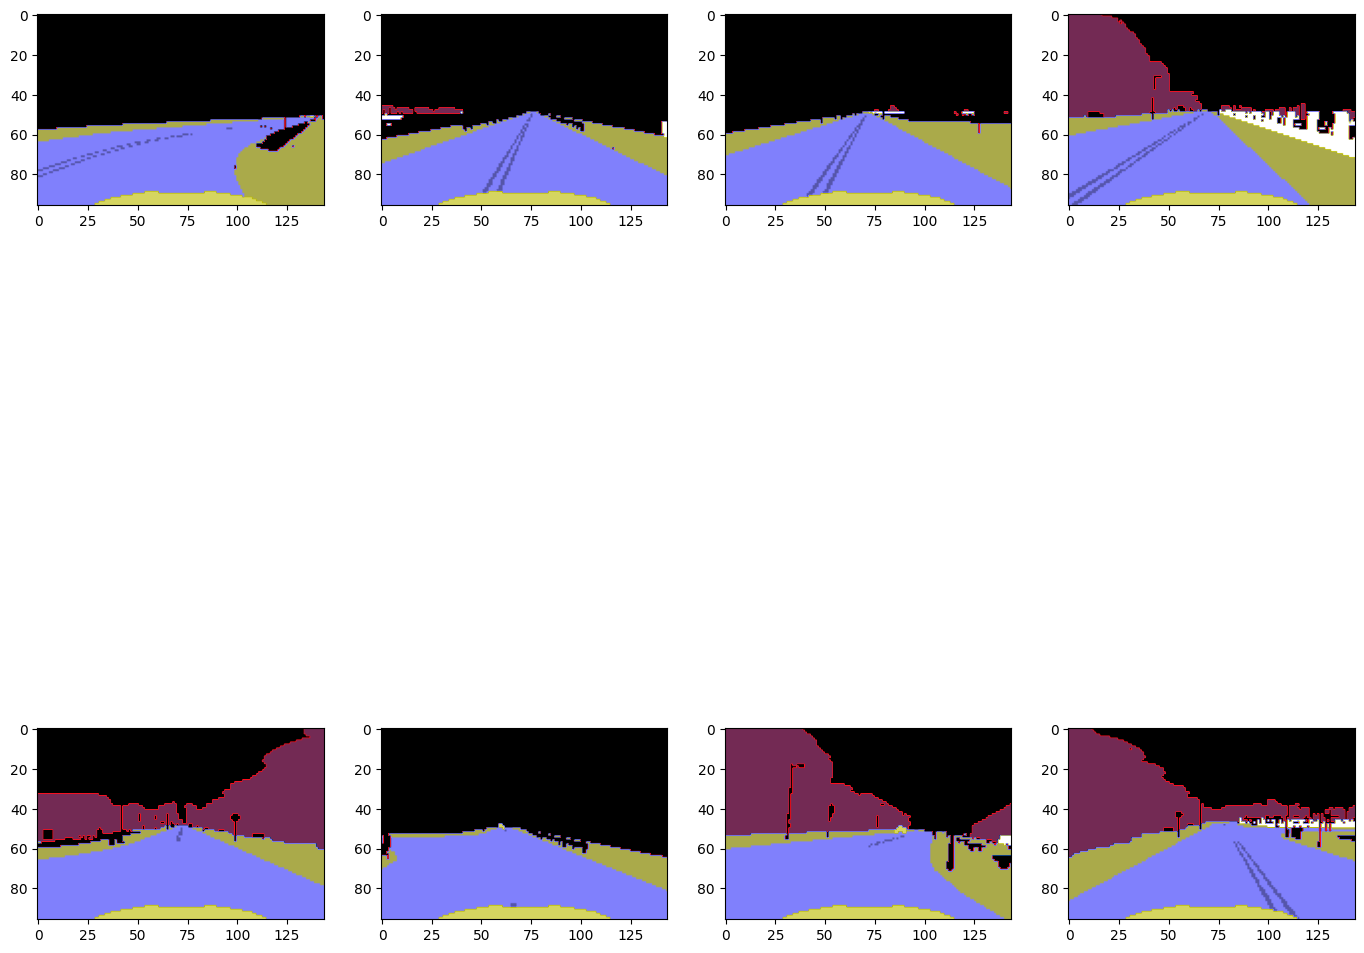

In [ ]:
fig=plt.figure(figsize=(17, 17))
columns = 4
rows = 2
for i in range(1, columns*rows + 1):
    img = X[i-1]
    print(img.shape)
    fig.add_subplot(rows, columns, i)
    plt.imshow(categorical_to_img(img), cmap='gist_stern', vmin=0, vmax=len(needed_labels) - 1)
plt.show()



In [ ]:
from PIL import Image
from numpy import asarray
from google.colab.patches import cv2_imshow
import cv2


# load the image and convert into
# numpy array
img = Image.open("/content/output_10.jpg")


# asarray() class is used to convert
# PIL images into NumPy arrays
numpydata = asarray(img)
resized_img = cv2.resize(numpydata, (300, 200))

# <class 'numpy.ndarray'>
print(type(numpydata))

#  shape
print(numpydata.shape)

cv2_imshow(img_to_categorical(resized_img, needed_labels))

<class 'numpy.ndarray'>
(256, 256, 3)


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 7


In [ ]:
fig=plt.figure(figsize=(17, 17))
columns = 8
rows = 8
for i in range(1, columns*rows + 1):
    #img = X[i-1]
    pred = model.predict(np.array([img]))
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.rot90(categorical_to_img(pred[0]), 3), cmap='gist_stern', vmin=0, vmax=len(needed_labels)-1)
plt.show()

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 96, 144, 7), found shape=(None, 256, 256, 3)


<Figure size 1700x1700 with 0 Axes>

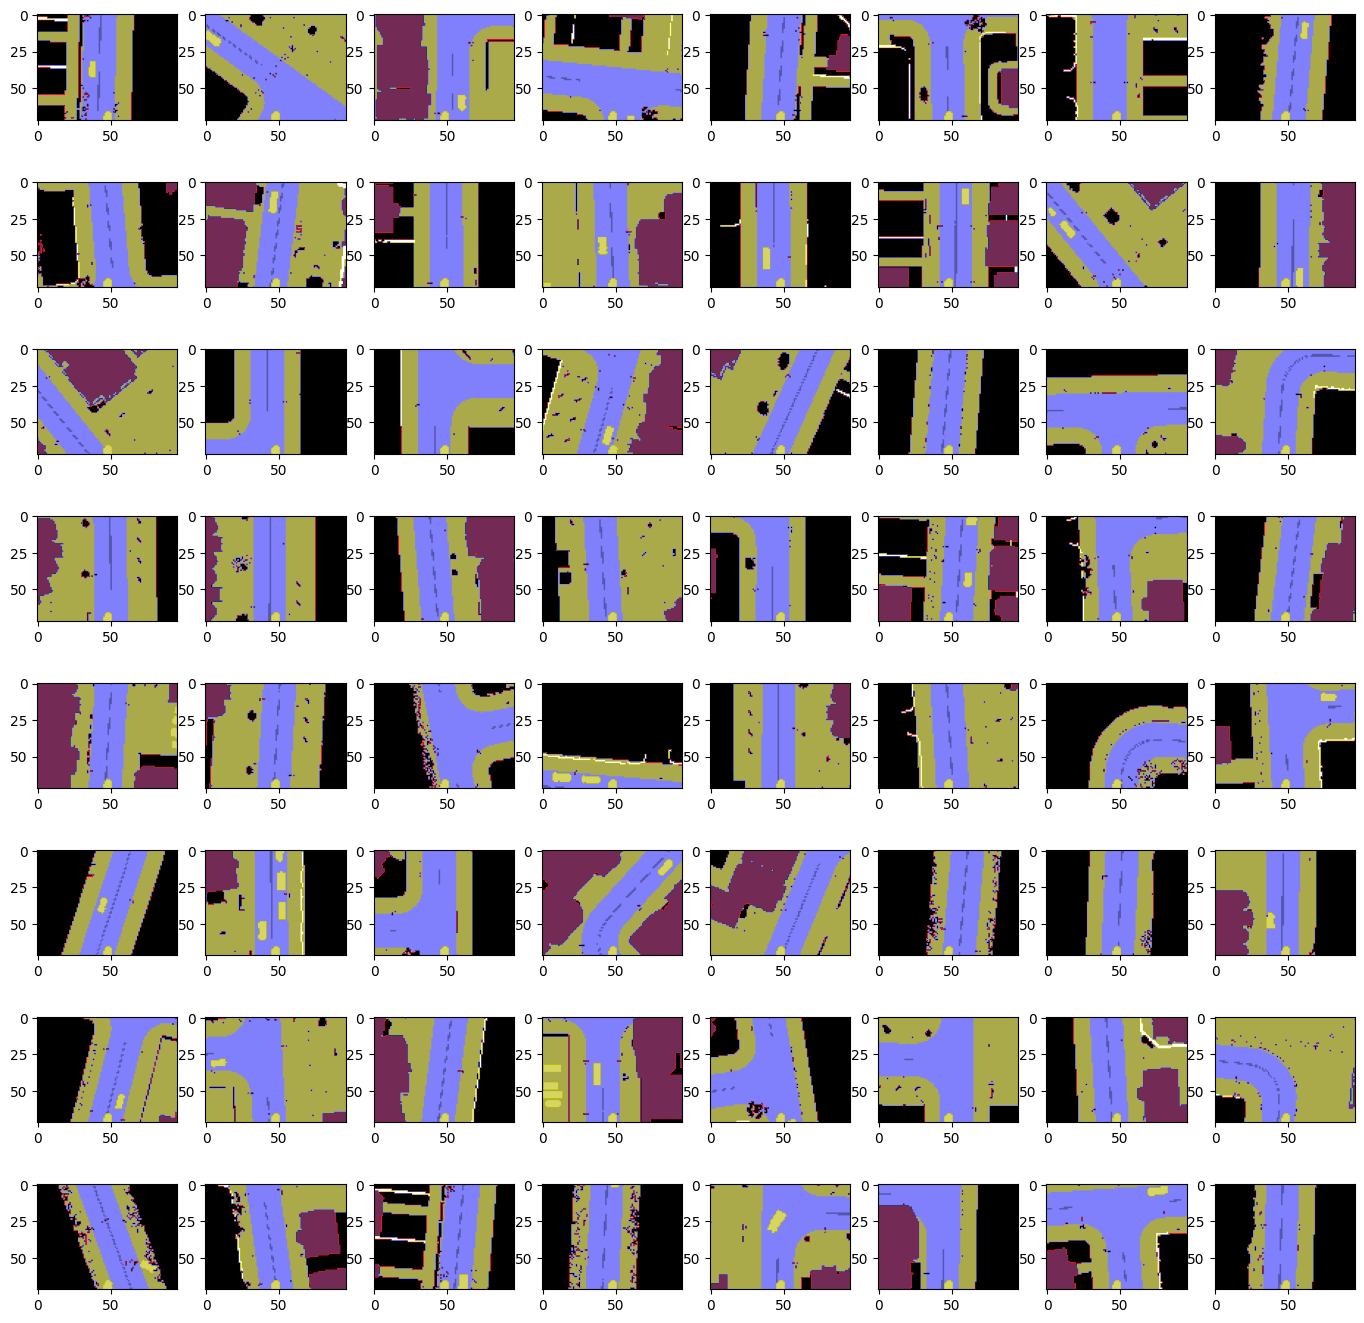

In [ ]:
fig=plt.figure(figsize=(17, 17))
columns = 8
rows = 8
for i in range(1, columns*rows + 1):
    img = y[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.rot90(categorical_to_img(img), 3), cmap='gist_stern', vmin=0, vmax=len(needed_labels)-1)

In [ ]:
## Use this and play video on your own pc by loading the numpy array.

imgs = []
print(len(X))
for i in range(len(X)):
  img = X[i]
  pred = model.predict(np.array([img]))
  img = np.rot90(categorical_to_img(pred[0]), 3)
  plt.imsave("image{0}.jpg".format(i), img)

np.save('output7', np.array(imgs))

64
1/1 [==============================] - 0s 27ms/step


In [ ]:
import cv2
import os
import numpy as np

# Specify the path to your folder containing JPG images
image_folder = '/content/images'
video_name = 'output_video.mp4'

# Specify the desired video properties
frame_width = 1000
frame_height = 1080
fps = 1

# Initialize the VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # You can also try 'avc1' for H.264 codec
video = cv2.VideoWriter(video_name, fourcc, fps, (frame_width, frame_height))

# Get all files in the folder
images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
images.sort()  # Sort the images by name

# Read and write each image to the video
for image in images:
    img_path = os.path.join(image_folder, image)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (frame_width, frame_height))
    video.write(img)

# Release the VideoWriter object
video.release()

print("Video creation completed.")


Video creation completed.


In [ ]:
%cd '/content/input'
print(len(X))
for i in range(len(X)):
  img = X[i]
  img = categorical_to_img(img)
  plt.imsave("{0}.jpg".format(i), img)

/content/input
64


In [ ]:
import cv2
import os
import numpy as np

# Specify the path to your folder containing JPG images
image_folder = '/content/input'
video_name = 'input_video.mp4'

# Specify the desired video properties
frame_width = 1000
frame_height = 1080
fps = 1

# Initialize the VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # You can also try 'avc1' for H.264 codec
video = cv2.VideoWriter(video_name, fourcc, fps, (frame_width, frame_height))

# Get all files in the folder
images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
images.sort()  # Sort the images by name

# Read and write each image to the video
for image in images:
    img_path = os.path.join(image_folder, image)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (frame_width, frame_height))
    video.write(img)

# Release the VideoWriter object
video.release()

print("Video creation completed.")


Video creation completed.


In [ ]:
import numpy as np
import cv2

# Load the images from the saved file
imgs = np.load('output7.npy')  # Make sure to include the .npy extension
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MJPG')  # You can also use other codecs like 'XVID' or 'MJPG'
height, width = imgs[0].shape
video = cv2.VideoWriter('output_video.mp4', fourcc, 20.0, (width, height))

for img in imgs:
    video.write(img)

video.release()